In [27]:
import fastText
import pandas as pd
import re
import numpy as np
import csv
import os
from scipy import stats
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
df = pd.read_csv('data/amazon_reviews.csv')
df = df['Score', 'Text']
df['Text'] = df['Text'].apply(lambda x: re.sub(r"([.\\!?,'/()])", r" \1 ", x.lower()))

In [21]:
with open('data/ft_amazon_review_sg.txt', 'w') as f:
    for line in df['Text'].values:
        f.write(line)
        f.write('\n')

In [22]:
sg_model = fastText.train_unsupervised(input='data/ft_amazon_review_sg.txt', model='skipgram', )

In [24]:
# Because of fasttext we don't need to account for OOV
def compute_similarity(data_path, model):
    def similarity(v1, v2):
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        return np.dot(v1, v2) / n1 / n2

    mysim = []
    gold = []

    with open(data_path, 'rb') as fin:
        for line in fin:
            tline = line.split()
            word1 = tline[0].lower()
            word2 = tline[1].lower()

            v1 = model.get_word_vector(word1)
            v2 = model.get_word_vector(word2)
            d = similarity(v1, v2)
            mysim.append(d)
            gold.append(float(tline[2]))

    corr = stats.spearmanr(mysim, gold)
    dataset = os.path.basename(data_path)
    correlation = corr[0] * 100
    return dataset, correlation, 0

In [26]:
dataset, corr, oov = compute_similarity('data/rw/rw.txt', sg_model)
print("{0:20s}: {1:2.0f}  (OOV: {2:2.0f}%)".format(dataset, corr, 0))

rw.txt              : 32  (OOV:  0%)


In [31]:
count = 0
for j in sg_model.get_words()[20:]:
    print(j)
    count += 1
    if  count == 20:
        break

you
with
have
not
are
was
<br
they
s
t
as
on
><br
like
so
these
)
them
(
good


In [34]:
sg_model.get_word_vector('they')

array([ 0.09427449,  0.21040338, -0.10112232, -0.18027182, -0.06420133,
        0.6949959 , -0.32311782,  0.32558468,  0.2936747 ,  0.13819923,
       -0.06235039,  0.24966162, -0.40748212,  0.08620415, -0.1525534 ,
        0.09475082, -0.09127166, -0.05679758, -0.08318012,  0.06808638,
        0.07992063, -0.08928107,  0.06477964, -0.0811705 , -0.40352845,
       -0.23176348,  0.02109735,  0.4525092 ,  0.01557064,  0.34279335,
        0.07168002, -0.0627816 , -0.02888379,  0.01262861, -0.24251458,
        0.13459975,  0.22922572,  0.15688992,  0.05527925, -0.12706351,
       -0.20584743, -0.02566395,  0.27696055,  0.0592207 , -0.13424668,
        0.05087655, -0.13432784, -0.05932631, -0.11384568,  0.21147613,
       -0.27626792,  0.2689693 , -0.12061743,  0.31388873, -0.0234402 ,
       -0.1879519 ,  0.09270612, -0.10146701,  0.25364554, -0.25622493,
        0.02512721, -0.01557622,  0.16899529, -0.15504616, -0.08640929,
        0.02225807, -0.09254209, -0.30455342,  0.10481967, -0.17

In [48]:
words = ['hot', 'water', 'drink', 'tea', 'cofee', 'cup', 
         'price', 'buy', 'order', 'recommend', 
         'different', 'tried', 'been',  'years',
         'good', 'nice', 'great', 'delicious']

In [53]:
def tsne_plot(model):
    """
    Creates and TSNE model and plots it
    inspired from tsne for gensim word2vec: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
    """
    labels = []
    tokens = []

    for word in model.get_words()[20:300]: # not using the first 20 as they are mostly most common words
#     for word in words:
        tokens.append(model.get_word_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    labeling = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
    for index, value in enumerate(new_values):
        if labels[index] in words:
            x.append(value[0])
            y.append(value[1])
            labeling.append(labels[index])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
        plt.annotate(labeling[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

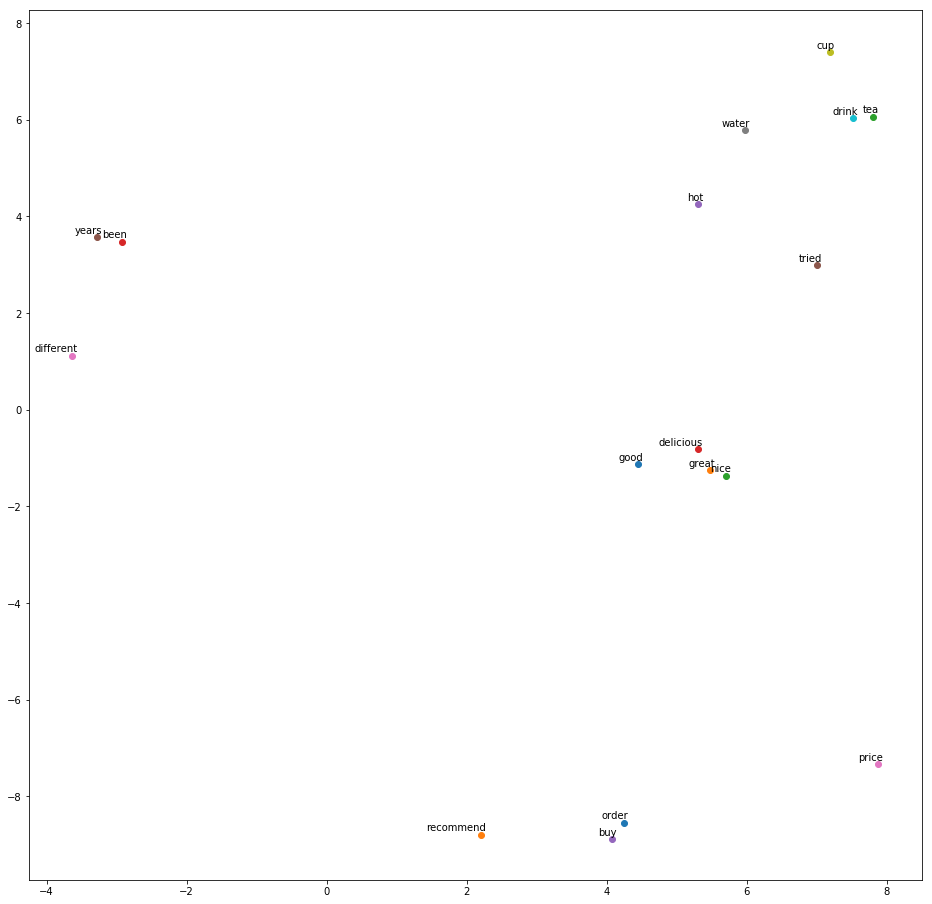

In [54]:
tsne_plot(sg_model)